## Imports etc

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf, acf

import utils

pd.set_option('display.max_columns', 500)

FREQ = '05S'  # '05S', not '5S', if you want to run it on 5 seconds
DATA_COL = 'ma_slope'
CORR_THRESHOLD = 0.50

CALC_STATIONARITY = True  # takes long
PLOT_AUTOCORRS = True  # 40+ plots about the autocorrelation of each sensor

LOAD_MAX_CORRS = True  # if you have them in 'data/' folder, don't calculate but load them, saves a lot of time
LOAD_CORR_MATRICES = True  # same as above

Calculate the maximum number of lags using the given frequency. Max number of lags == 10 minutes

In [2]:
MAX_LAGS_ONE_DIR = int(600/int(FREQ[:-1]))
MAX_LAGS_ONE_DIR

120

## Load interpolated data

From Q1

In [3]:
interpolated_data = utils.load_interpolated_data()

In [4]:
interpolated_data

,Tag,TS,avg,UoM
0,CCUA4846210,2020-06-12 00:00:00,84.27450,flow
1,CCUA4846210,2020-06-12 00:00:05,78.04725,flow
2,CCUA4846210,2020-06-12 00:00:10,83.14800,flow
3,CCUA4846210,2020-06-12 00:00:15,66.72600,flow
4,CCUA4846210,2020-06-12 00:00:20,77.24625,flow
...,...,...,...,...
2246460,KGFQ7639756,2020-06-13 23:59:40,2.83500,0
2246461,KGFQ7639756,2020-06-13 23:59:45,2.83500,0
2246462,KGFQ7639756,2020-06-13 23:59:50,2.83500,0
2246463,KGFQ7639756,2020-06-13 23:59:55,2.83500,0


In [5]:
# number of unique sensors in the data
interpolated_data['Tag'].nunique()

65

## Q3 Question:

Because the product has to flow through the line, the sensor responses are expected to show correlations with each other. However, there will be a certain time delay between the sensor data relative to each other. The suggested way to extract this delay is to correlate the data sequences and find the time shift that achieves the highest correlation (there may be other ways). How are the sensors correlated and what are the relative time delays? What are the relative time delays of the actual physical disturbances of the product flow? Note that for the latter question, the answer to Question 1 may affect your result. Also note that the dataset has a high time resolution. This emphasizes high frequency fluctuations, which may make it difficult to find the correlations of sensors that are further apart and therefore have a larger lag. Please report if you find wildly unlikely results and suspect that time stamps were incorrect (can this be corrected?).

General note: High time resolution dataset and therefore there are probably high frequency fluctuations. Sensors that are far apart probably have a large time lag. 

The products have a processing time of max 10 minutes, therefore, keep the lags under this. 

# Average data

## Augmented Dickey-Fuller Test for Stationarity

Tests whether the mean and variance stay constant over time for each sensor. 

In [6]:
unique_sensors_avg_data = interpolated_data['Tag'].unique().tolist()  # get a list of all unique sensors that we are dealing with

  0%|                                                                                           | 0/65 [00:00<?, ?it/s]

Calculating stationarity
Using data_col: avg


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [04:40<00:00,  4.32s/it]


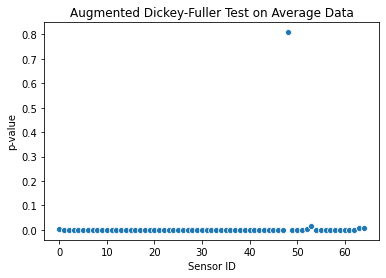

In [7]:
if CALC_STATIONARITY:
    print("Calculating stationarity")
    p_values = utils.calc_p_values_stationarity(smoothend_df=interpolated_data,
                                                sensor_list=unique_sensors_avg_data,
                                                data_col='avg',
                                                title="Augmented Dickey-Fuller Test on Average Data"
                                                )
else:
    print("Don't calculate.")

In [9]:
if CALC_STATIONARITY:
    average_stationarity_df = pd.DataFrame(data={
                                                    'sensor': unique_sensors_avg_data,
                                                    'p_values': p_values,
    })
    print(average_stationarity_df.sort_values('p_values', ascending=False).head(10))
#     average_stationarity_df.to_excel(utils.PATH_AVG_P_VALUES)
else:
    print("Didn't calculate.")

         sensor      p_values
48  VOJU5732246  8.087084e-01
53  KKSV5218886  1.407758e-02
63  DYPZ7187588  9.087980e-03
64  KGFQ7639756  8.051126e-03
0   CCUA4846210  2.696902e-03
52  GJWD1249502  1.973473e-03
62  SKGH6792105  6.535132e-05
51  SINT4409168  2.617599e-05
32  VKBD2463131  6.017133e-06
49  MZWG6597875  2.965406e-10


## Autocorrelation plots

According to paper [https://link.springer.com/article/10.3758/s13428-015-0611-2], you can't make accurate cross correlation that represent the reality, if the individual sensors have a high autocorrelation. Therefore, we'll look into whether there is autocorrelation, and if so, we try to remove it. 

Creating autocorrelation plots. 


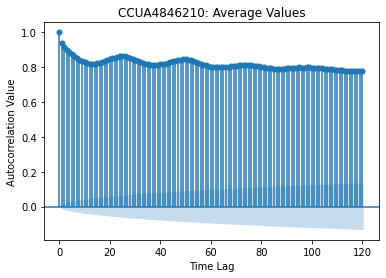

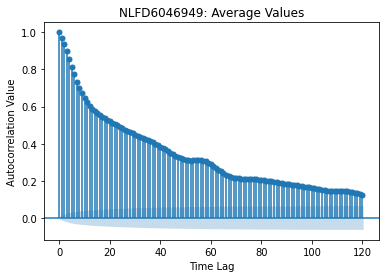

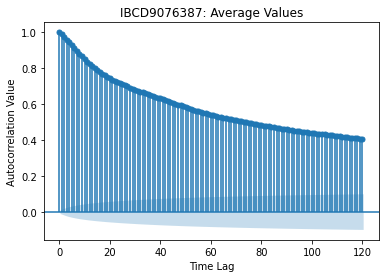

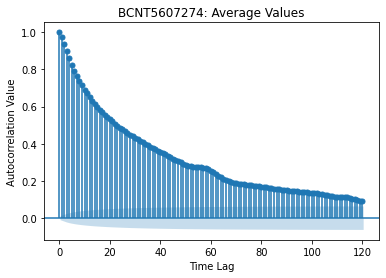

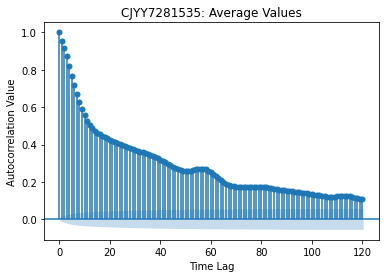

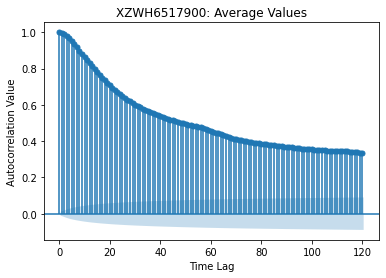

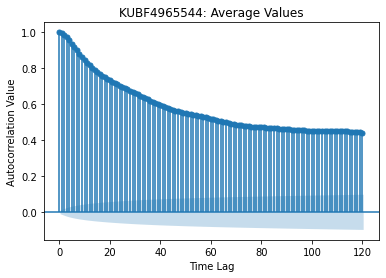

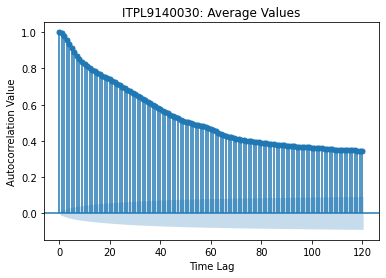

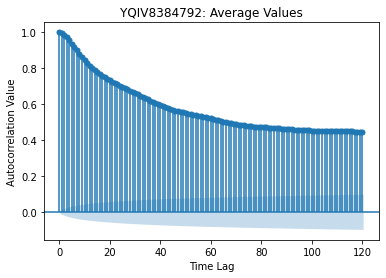

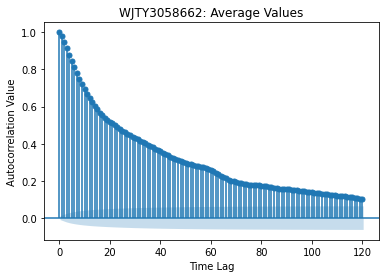

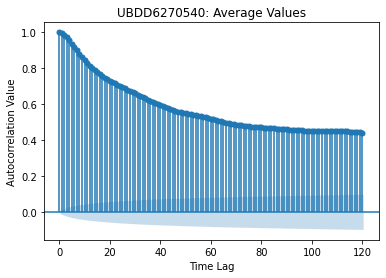

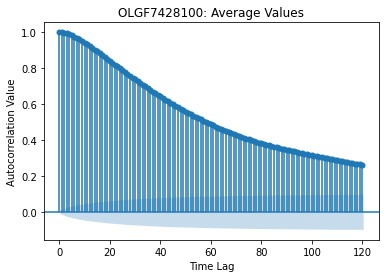

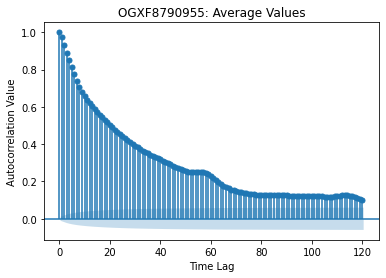

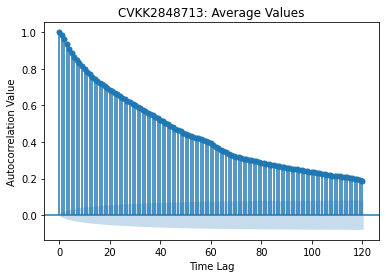

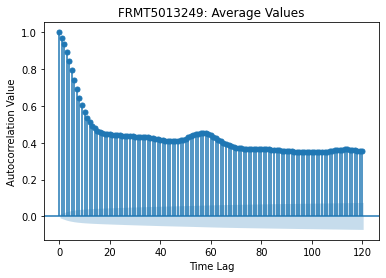

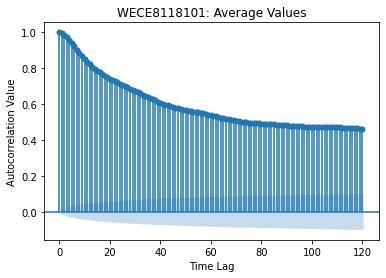

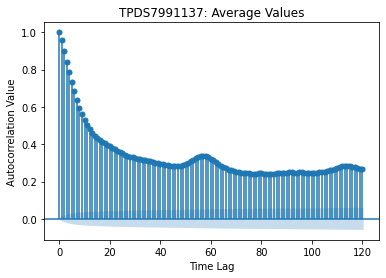

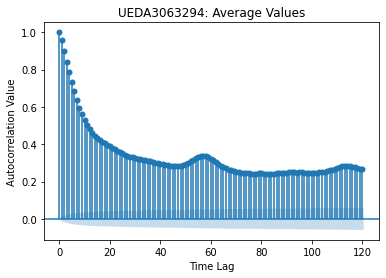

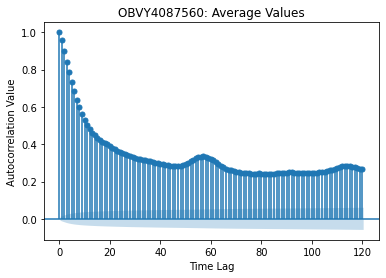

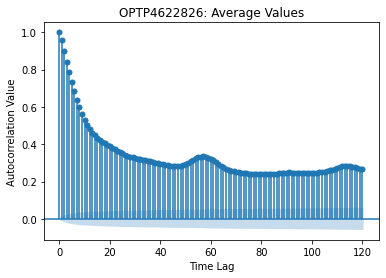

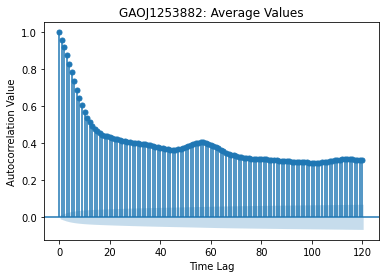

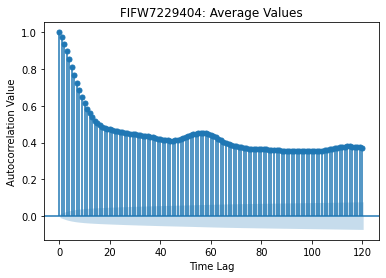

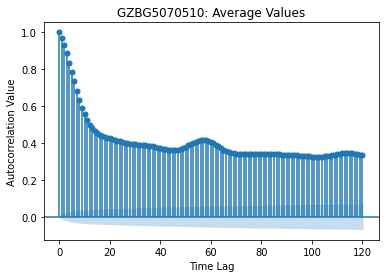

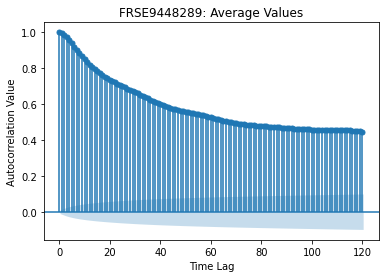

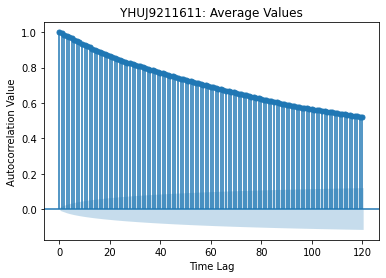

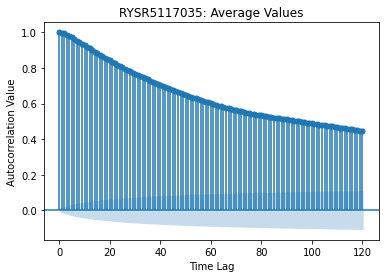

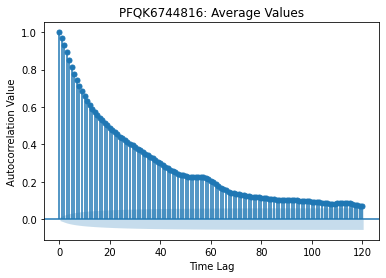

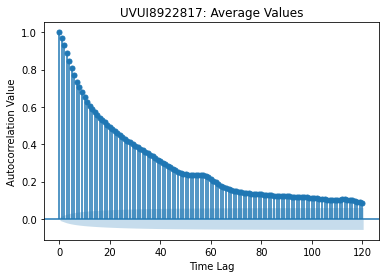

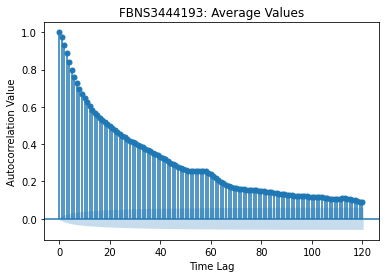

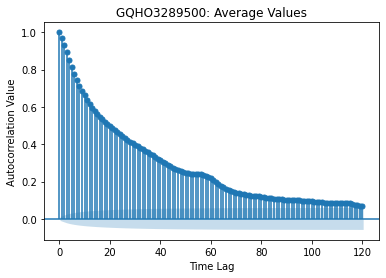

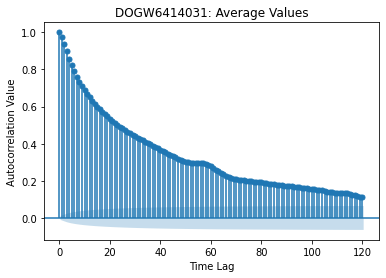

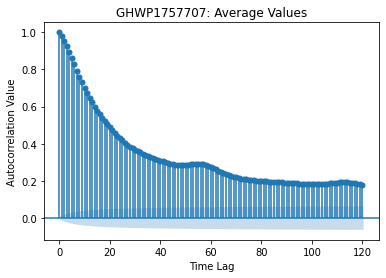

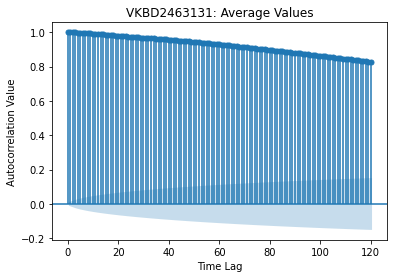

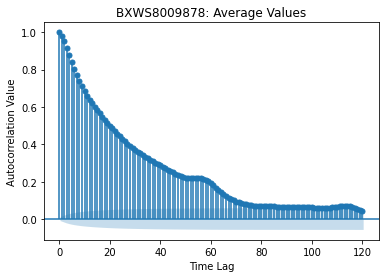

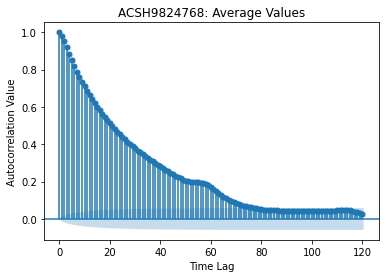

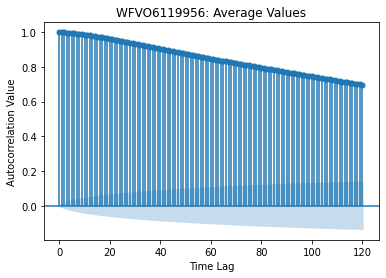

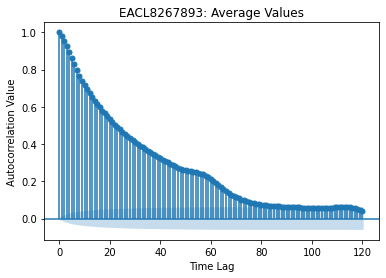

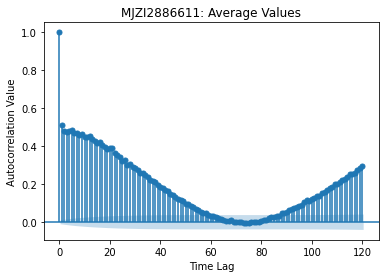

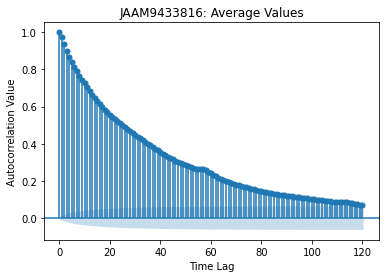

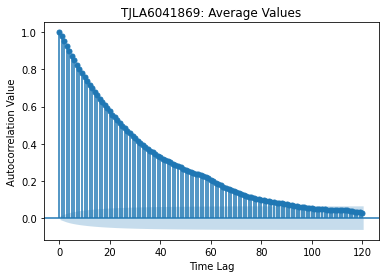

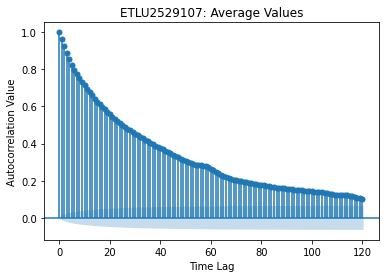

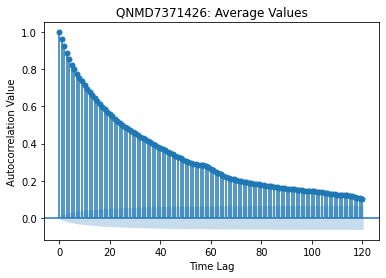

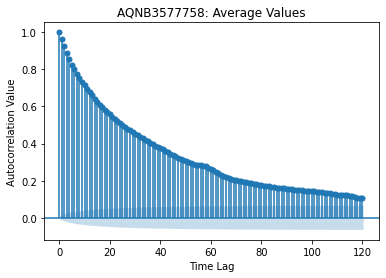

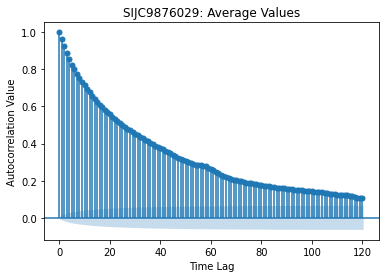

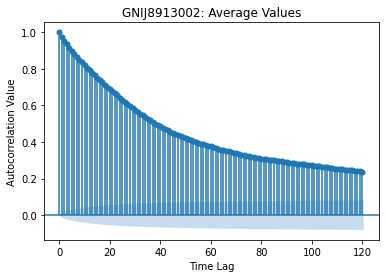

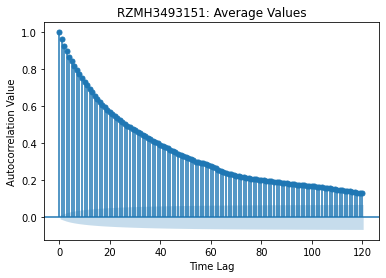

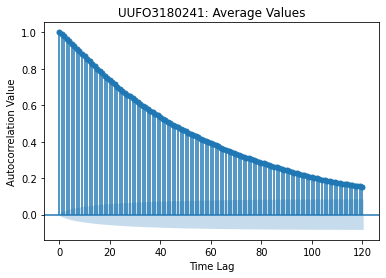

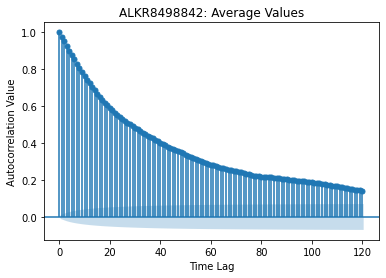

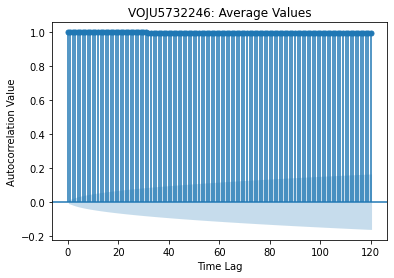

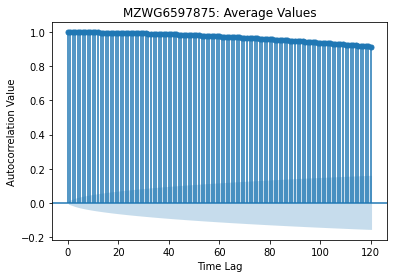

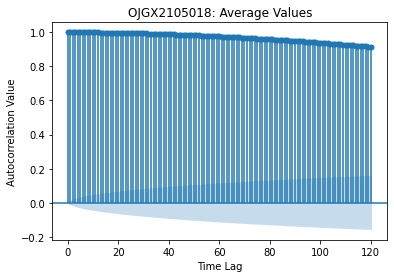

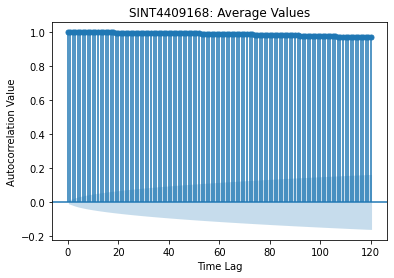

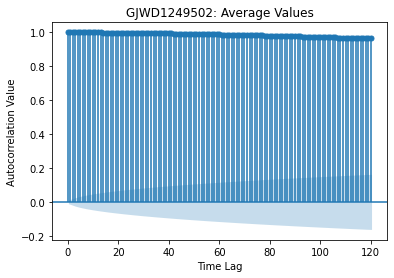

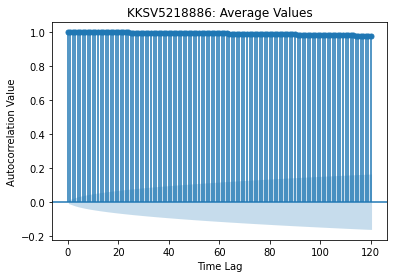

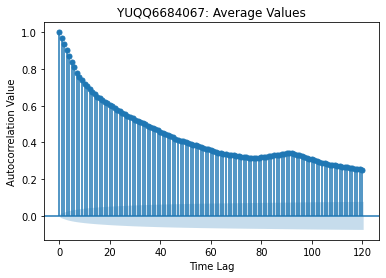

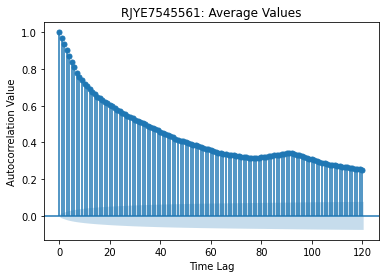

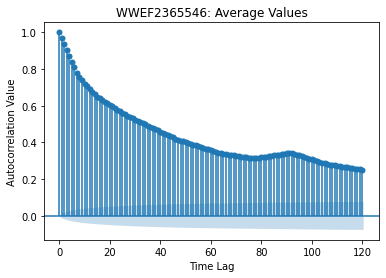

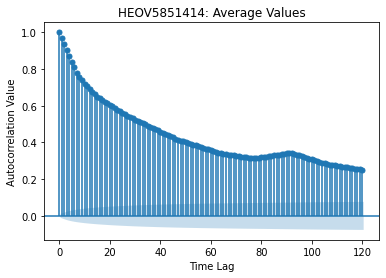

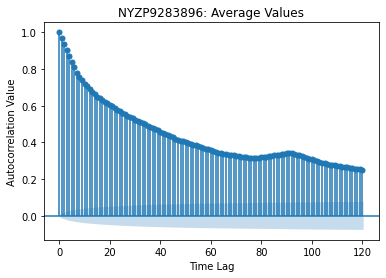

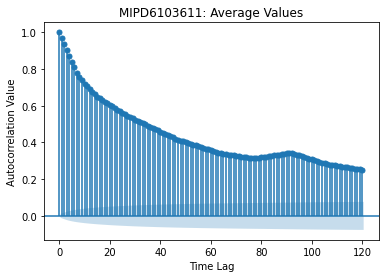

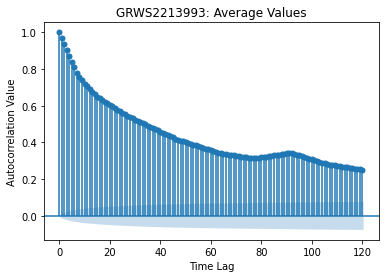

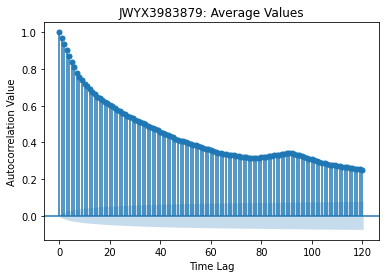

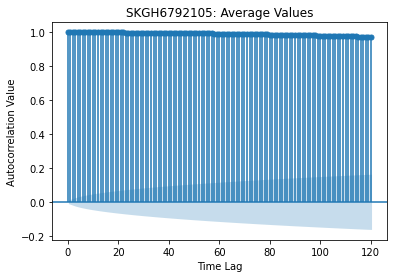

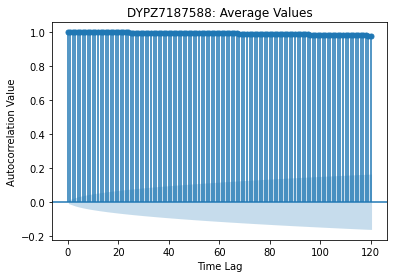

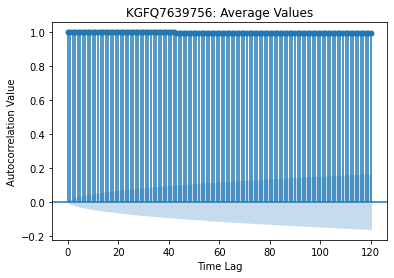

In [10]:
if PLOT_AUTOCORRS:
    print("Creating autocorrelation plots. ")
    utils.plot_autocorrs(frame=interpolated_data, 
                         sensor_list=unique_sensors_avg_data, 
                         data_col='avg',
                         max_lags_one_dir=MAX_LAGS_ONE_DIR, 
                         title_addition="Average Values",
                        )
else:
    print("Don't plot")

A lot of very high autocorrelations

# Prewhitening / Differencing:

Calculate the slope of the average values of the interpolated data.     
Thereafter, smooth the result using Moving Averages (MA).   
This has to be done per sensor type, which can thereafter be added together.    

In [11]:
all_sensors_df = interpolated_data.copy()

In [12]:
# how many and which sensor types?
all_sensors_types = all_sensors_df['UoM'].unique().tolist()
all_sensors_types

['flow',
 'pressure',
 'temperature',
 'current',
 'percentage',
 '0',
 'time',
 'frequency',
 'number',
 'categorical']

In [13]:
res = []
for sensor_type in all_sensors_types:
    deriv_df = utils.get_derivative_per_sensortype(sensor_type=sensor_type, 
                                                  interpolated_df=all_sensors_df, 
                                                  column_names=list(interpolated_data.columns),
                                                  reset_index=True,
                                                )
    
    smooth_deriv_df = utils.smooth_sensors_of_type(sensor_type=sensor_type, 
                                           derivative_df=deriv_df, 
                                           column_names=list(interpolated_data.columns), 
                                           window=5,
                                          )

    res.append(smooth_deriv_df)

In [14]:
result_df = pd.concat(res)

In [15]:
smooth_df = result_df.copy()

In [16]:
smooth_df['Tag'].nunique()

65

In [17]:
len(smooth_df)

2246465

In [18]:
all_unique_sensors = smooth_df['Tag'].unique().tolist()

## Augmented Dickey-Fuller Test for Stationarity
  
Tests whether the mean and variance stay constant over time for each sensor, but now on the prewhitened data.

  0%|                                                                                           | 0/65 [00:00<?, ?it/s]

Calculating stationarity
Using data_col: ma_slope


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [05:50<00:00,  5.39s/it]


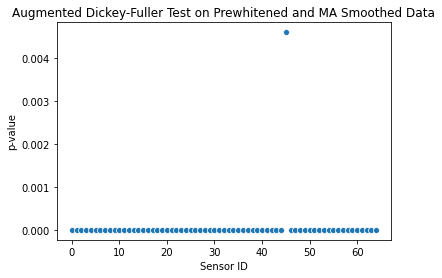

In [19]:
if CALC_STATIONARITY:
    print("Calculating stationarity")
    p_values = utils.calc_p_values_stationarity(smoothend_df=smooth_df,
                                                sensor_list=all_unique_sensors,
                                                data_col=DATA_COL,
                                                title="Augmented Dickey-Fuller Test on Prewhitened and MA Smoothed Data"
                                                )
else:
    print("Don't calculate.")

All have p value < 0.05 (way lower even), so all are significantly stationair. 

## Autocorrelation plots

Again make autocorrelation plots, but now on the prewhitenend data.

Creating autocorrelation plots. 


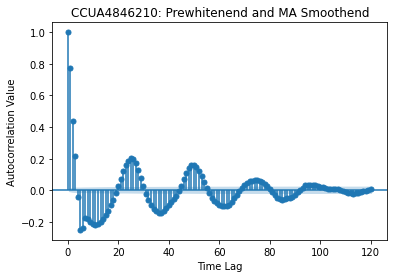

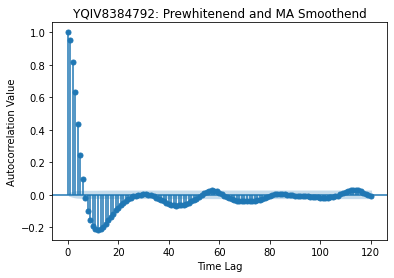

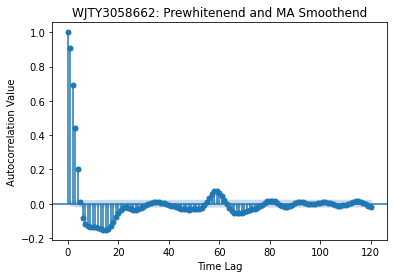

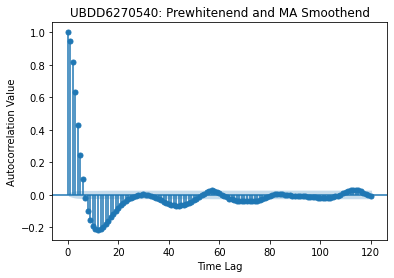

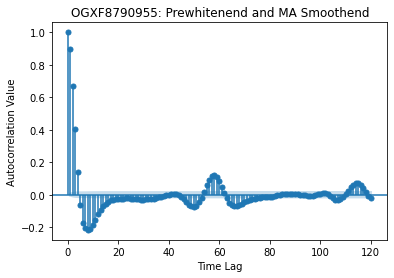

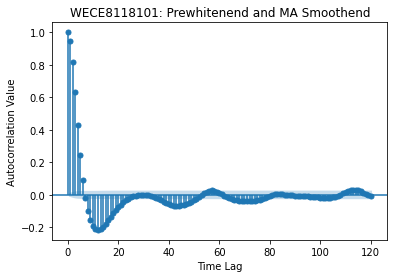

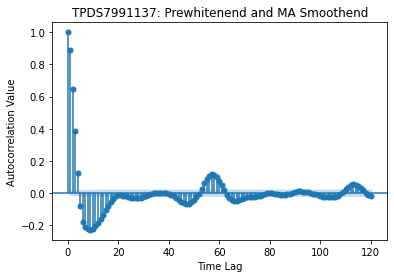

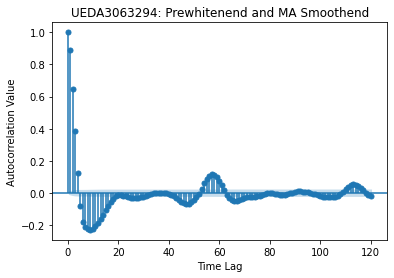

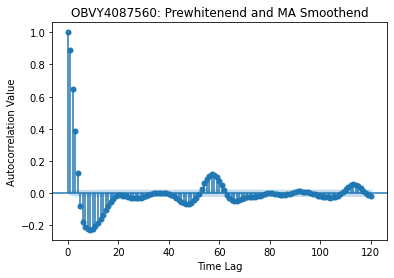

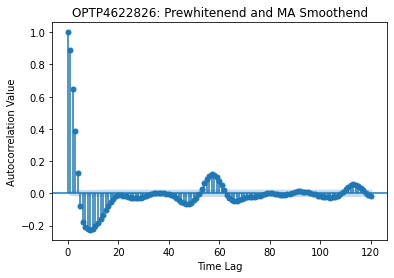

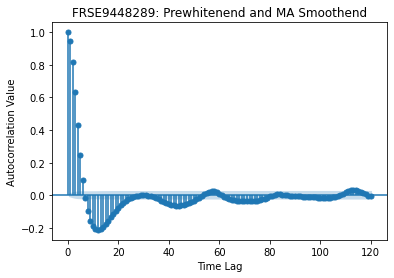

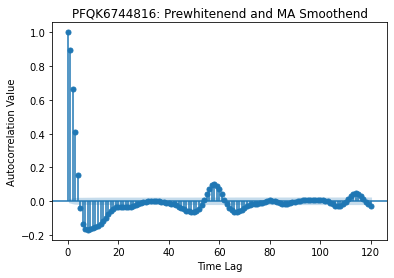

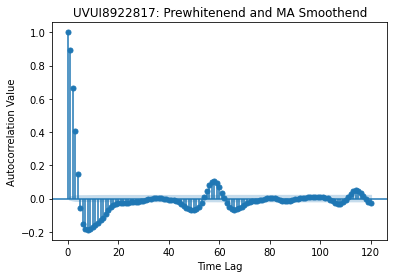

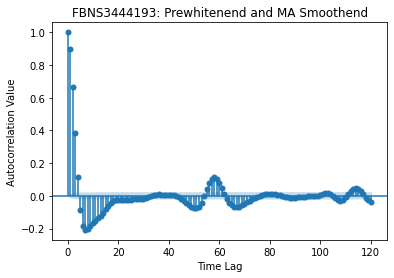

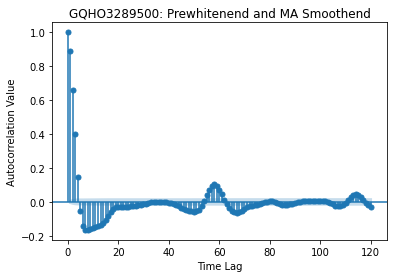

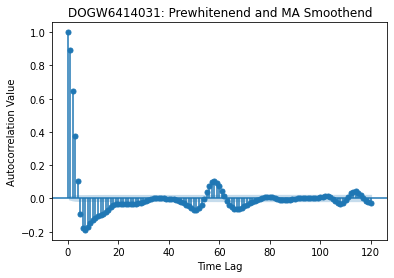

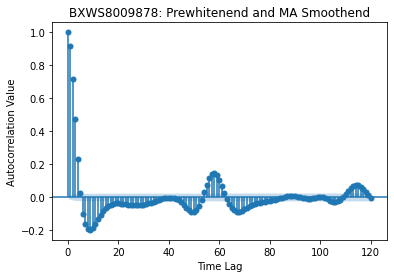

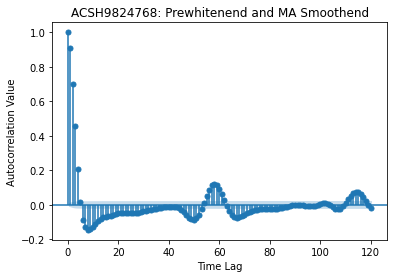

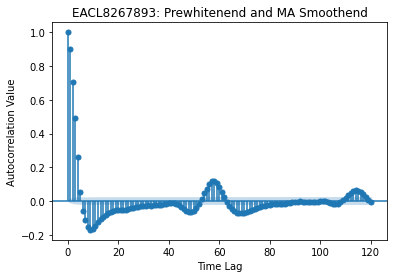

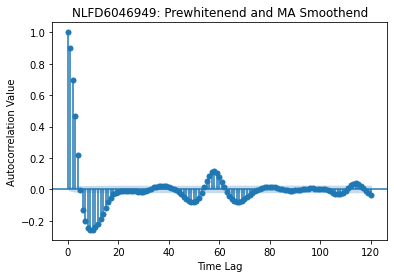

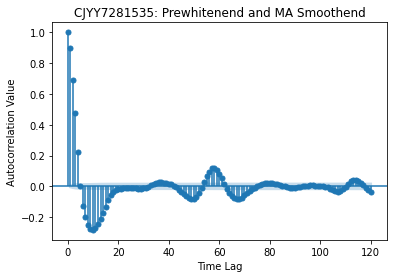

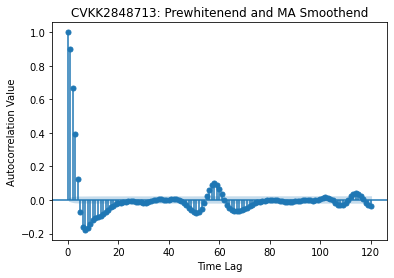

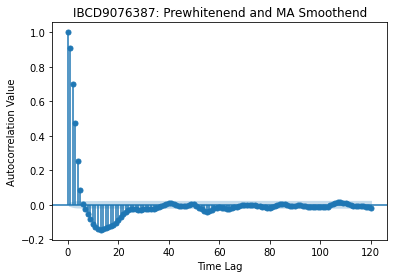

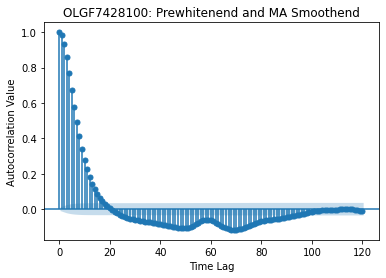

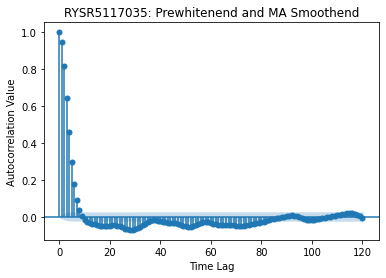

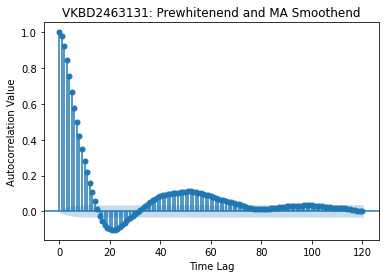

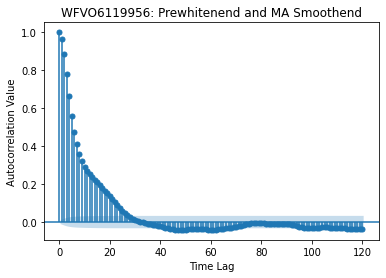

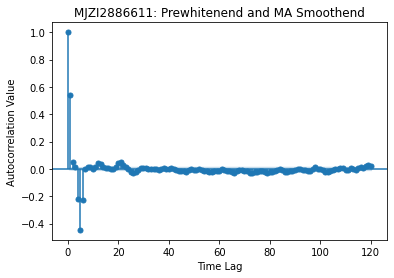

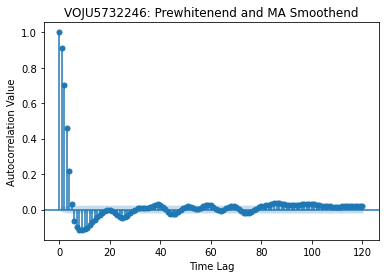

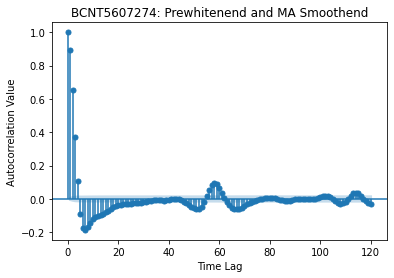

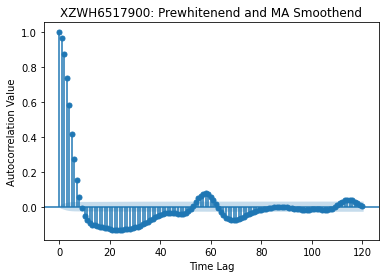

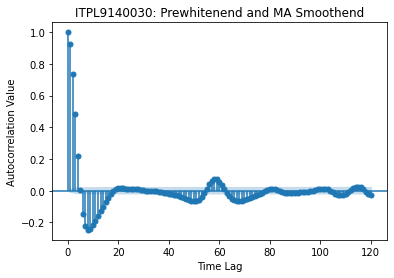

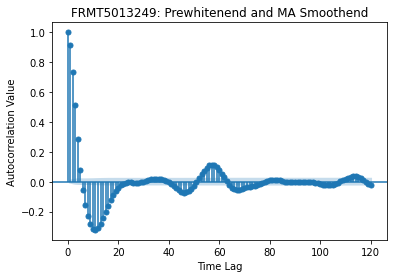

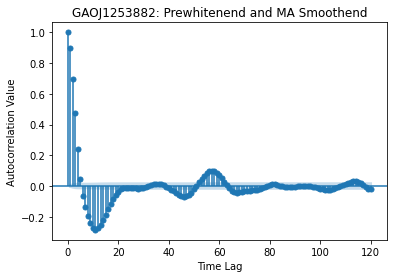

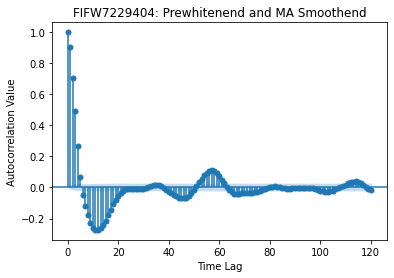

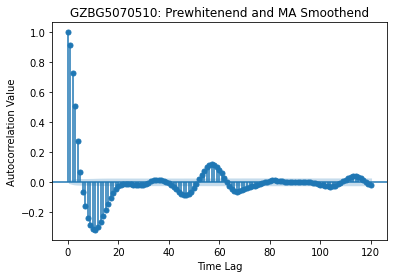

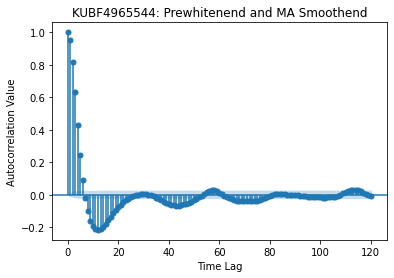

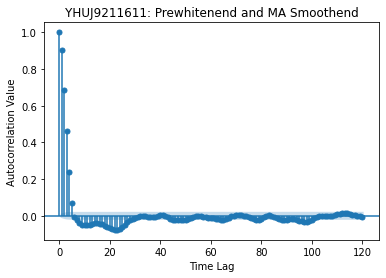

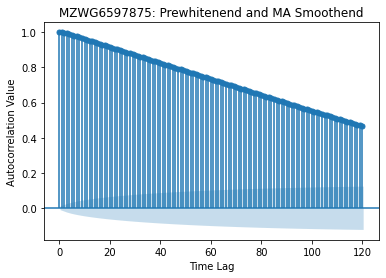

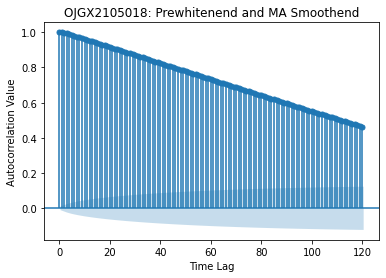

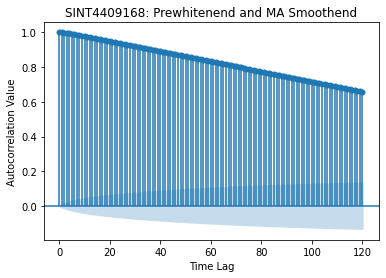

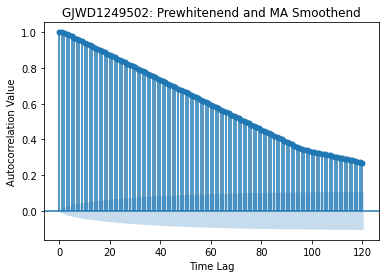

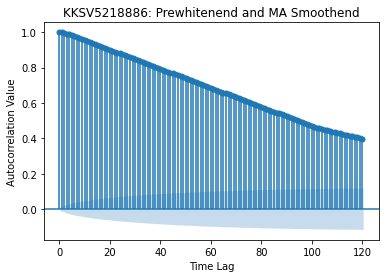

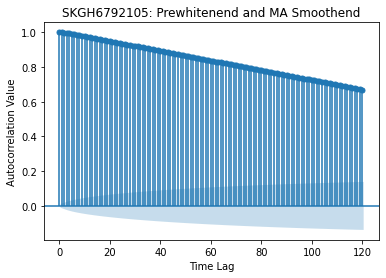

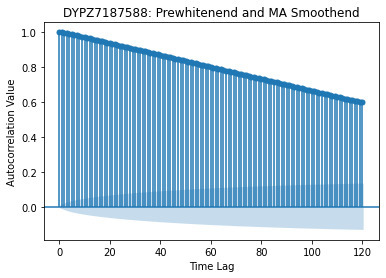

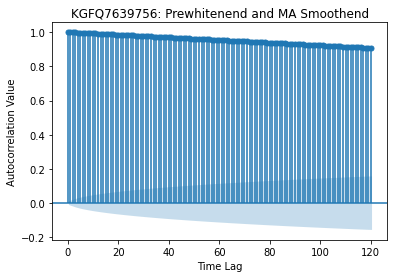

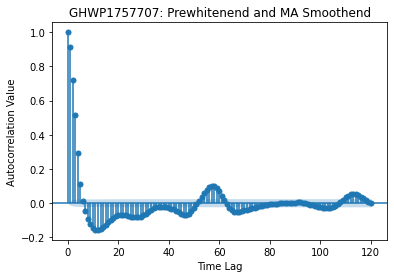

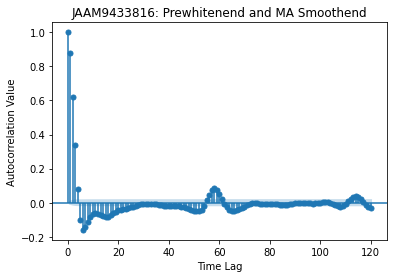

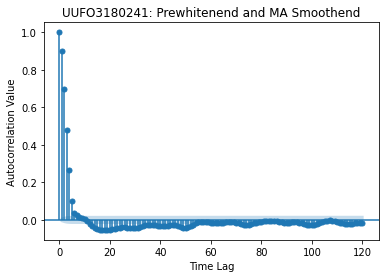

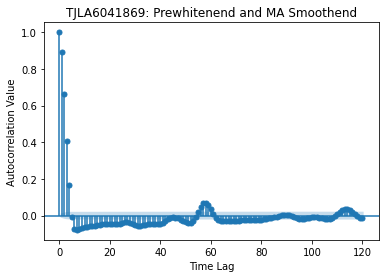

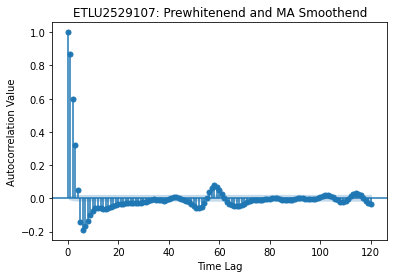

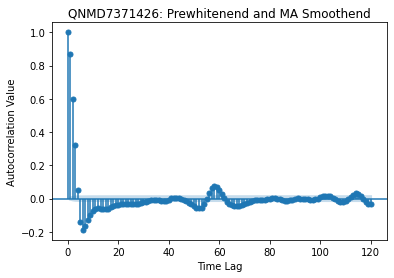

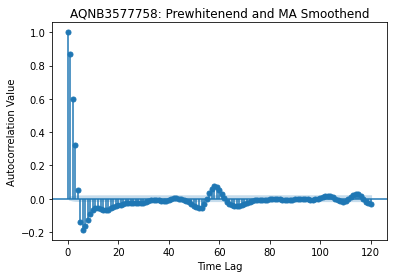

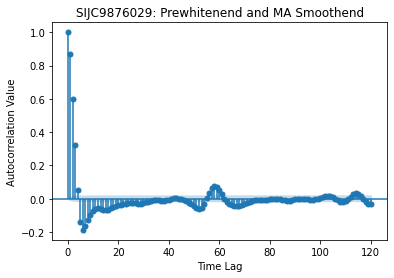

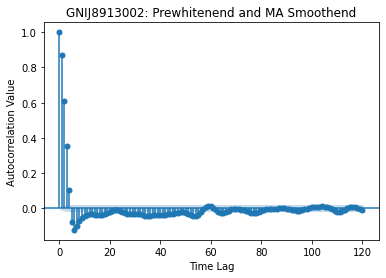

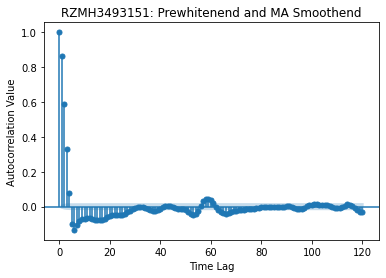

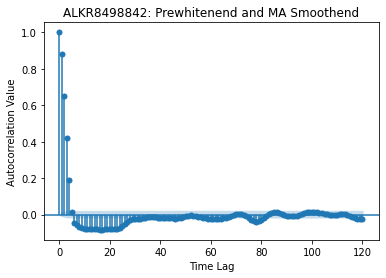

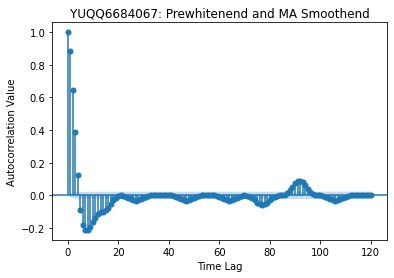

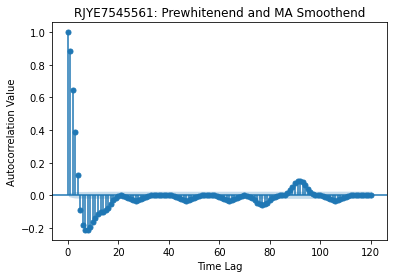

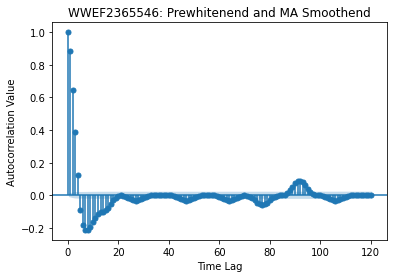

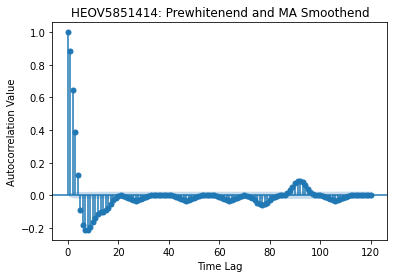

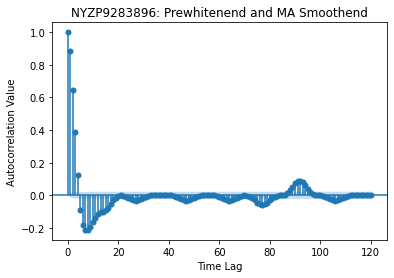

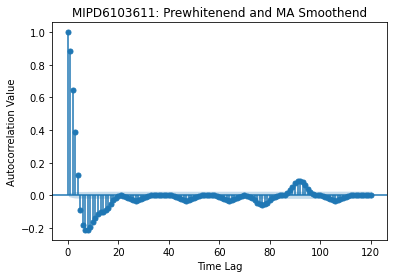

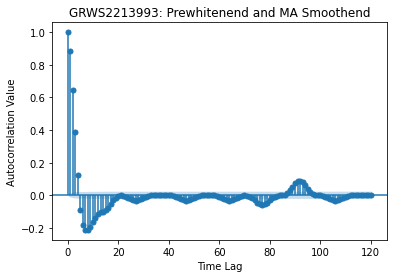

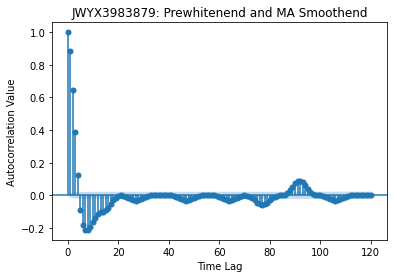

In [20]:
if PLOT_AUTOCORRS:
    print("Creating autocorrelation plots. ")
    utils.plot_autocorrs(frame=smooth_df, 
                         sensor_list=all_unique_sensors, 
                         data_col=DATA_COL,
                         max_lags_one_dir=MAX_LAGS_ONE_DIR, 
                         title_addition="Prewhitenend and MA Smoothend",
                        )
else:
    print("Don't plot")

# Calculate Cross-correlations

On differenced data.

## Get all sensor pairs that we want to calculate correlations for

In [21]:
sensor_pairs = utils.get_all_sensor_pairs(series = smooth_df['Tag'])

In [22]:
sensor_pairs[:3]

[['CCUA4846210', 'YQIV8384792'],
 ['CCUA4846210', 'WJTY3058662'],
 ['CCUA4846210', 'UBDD6270540']]

## Create correlation & lag matrices for all sensor pairs

In [23]:
smooth_df

,Tag,TS,avg,UoM,slope,ma_slope
0,CCUA4846210,2020-06-12 00:00:00,84.27450,flow,-6.227250,-6.227250
1,CCUA4846210,2020-06-12 00:00:05,78.04725,flow,-0.563250,-3.395250
2,CCUA4846210,2020-06-12 00:00:10,83.14800,flow,-5.660625,-4.150375
3,CCUA4846210,2020-06-12 00:00:15,66.72600,flow,-2.950875,-3.850500
4,CCUA4846210,2020-06-12 00:00:20,77.24625,flow,2.841375,-2.512125
...,...,...,...,...,...,...
34556,JWYX3983879,2020-06-13 23:59:40,0.00000,categorical,0.000000,0.000000
34557,JWYX3983879,2020-06-13 23:59:45,0.00000,categorical,0.000000,0.000000
34558,JWYX3983879,2020-06-13 23:59:50,0.00000,categorical,0.000000,0.000000
34559,JWYX3983879,2020-06-13 23:59:55,0.00000,categorical,0.000000,0.000000


In [24]:
if LOAD_CORR_MATRICES:
    full_corr_matrix, max_matrix, max_lag_matrix, min_matrix, min_lag_matrix = utils.load_all_corr_matrices()
    print("Loaded all correlation matrices. ")
else:
    print(f"Calculating all correlation matrices, using column: {DATA_COL} ")
    print(f"Number of unique sensors using: {len(all_unique_sensors)}")
    print(f"Max lags in one direction: {MAX_LAGS_ONE_DIR}")
    full_corr_matrix, max_matrix, max_lag_matrix, min_matrix, min_lag_matrix = utils.calc_corr_matrices(unique_sensor_list=all_unique_sensors, 
                                                                                                        smoothend_df=smooth_df,
                                                                                                        max_lags_one_dir=MAX_LAGS_ONE_DIR, 
                                                                                                        freq=FREQ,
                                                                                                        data_col=DATA_COL,
                                                                                                        )
    all_matrices = [full_corr_matrix, max_matrix, max_lag_matrix, min_matrix, min_lag_matrix]
    utils.save_all_corr_matrices(all_matrices)
    print("Saved all correlation matrices. ")

Loaded all correlation matrices. 


## Combine min and max matrices by taking absolute values of both

In [25]:
combine_matrix = np.empty(shape=max_matrix.shape)
for row in range(combine_matrix.shape[0]):
    for col in range(combine_matrix.shape[1]):
        combine_matrix[row][col] = max(max_matrix[row][col], abs(min_matrix)[row][col])

In [26]:
true_false_lag_matrix = combine_matrix == max_matrix

In [27]:
combine_lag_matrix = np.empty(shape=max_matrix.shape)
for row in range(true_false_lag_matrix.shape[0]):
    for col in range(true_false_lag_matrix.shape[1]):
        if true_false_lag_matrix[row][col] == True:
            combine_lag_matrix[row][col] = max_lag_matrix[row][col]
        else:
            combine_lag_matrix[row][col] = min_lag_matrix[row][col]

# Checkout Results

## Plot correlation matrices

Max correlation found for each sensor pair at a specific time lag, visualized as a heatmap. 

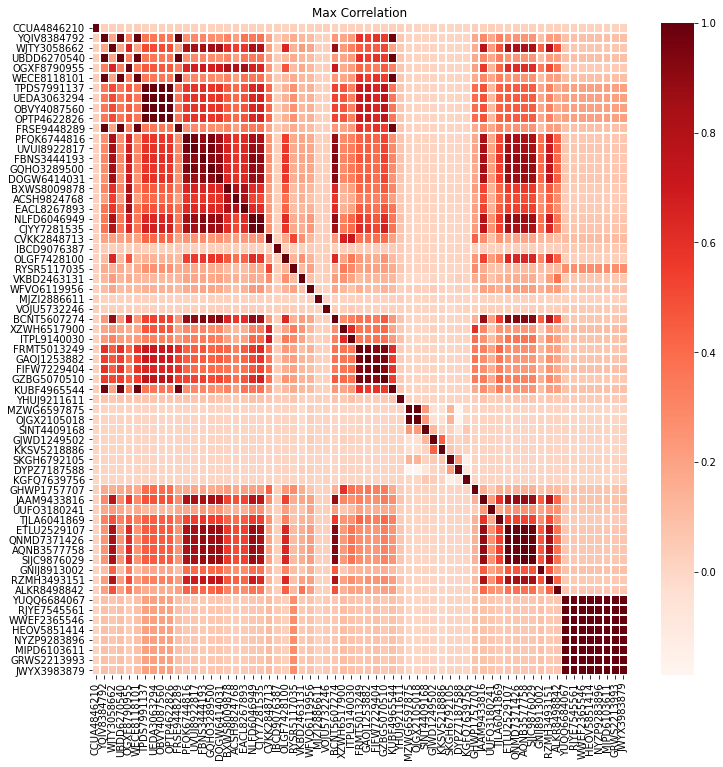

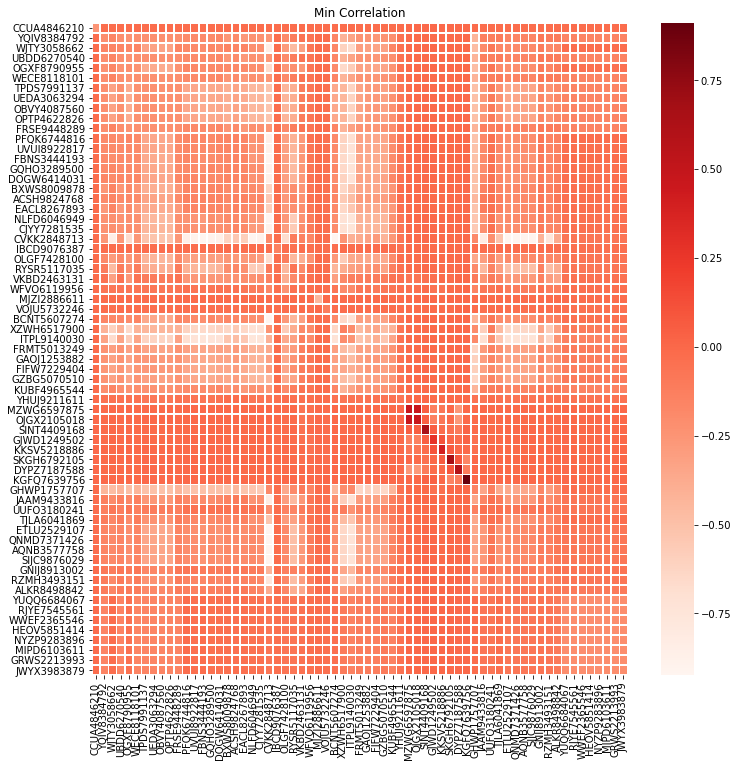

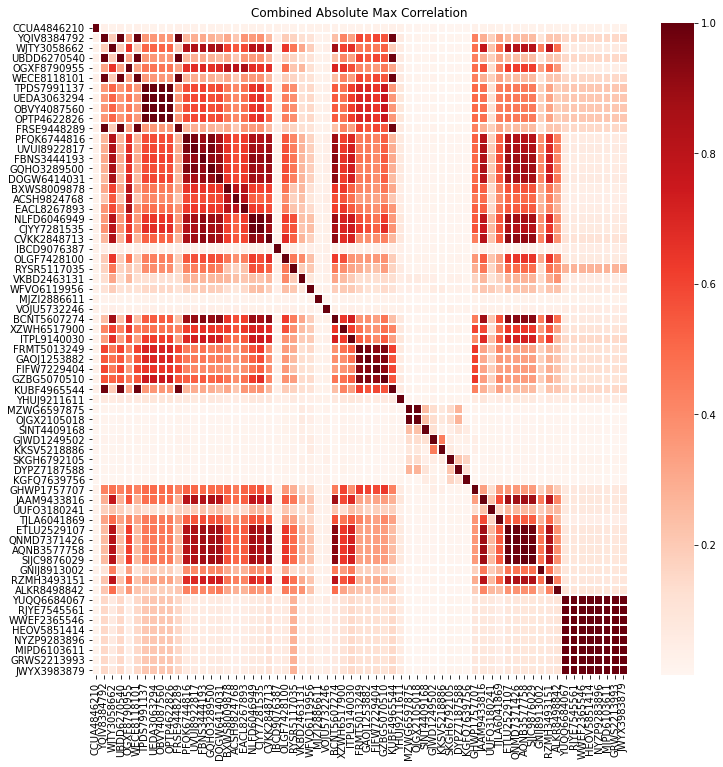

In [28]:
utils.plot_matrix(max_matrix, 
                  title="Max Correlation", 
                  xticklabels=all_unique_sensors, 
                  yticklabels=all_unique_sensors,
                 )
plt.show()
utils.plot_matrix(min_matrix, 
                  title="Min Correlation", 
                  xticklabels=all_unique_sensors, 
                  yticklabels=all_unique_sensors,
                 )
plt.show()
utils.plot_matrix(combine_matrix, 
                  title="Combined Absolute Max Correlation", 
                  xticklabels=all_unique_sensors, 
                  yticklabels=all_unique_sensors,
                 )
plt.show()

The most important heatmap is the third one: Combined Absolute Max Correlation, since that matrix takes into account both the minimum and maximum correlation values, in absolute. 

## Adapt lag scales

Lags are now on scale [0,240], but should be on [-120, 120]. Compensate:

In [29]:
substract = round(full_corr_matrix.shape[2] / 2)
print(f"Subtracting {substract}")
max_lag_matrix_comp = max_lag_matrix - substract
min_lag_matrix_comp = min_lag_matrix - substract
combine_lag_matrix_comp = combine_lag_matrix - substract

Subtracting 120


## Plot lag matrices

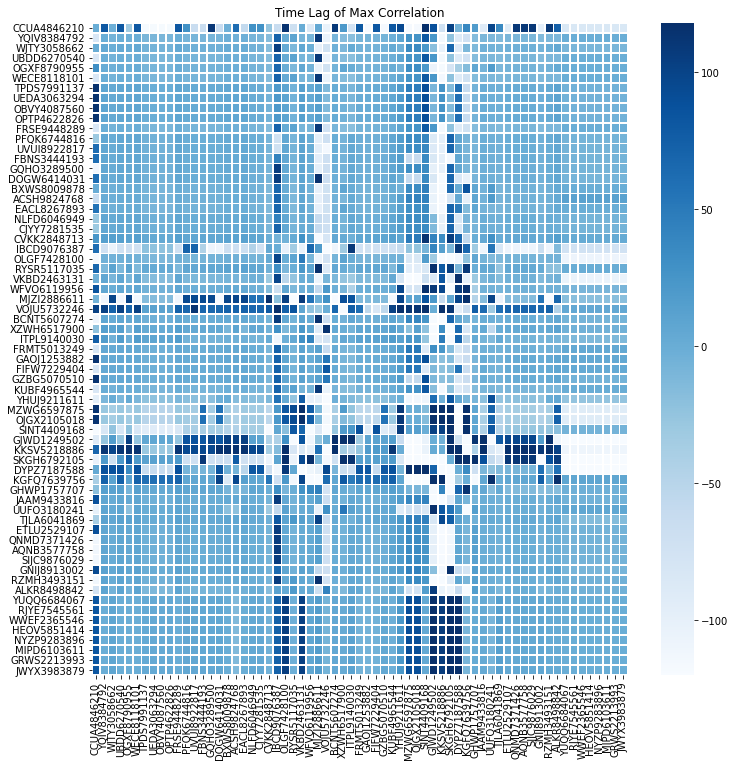

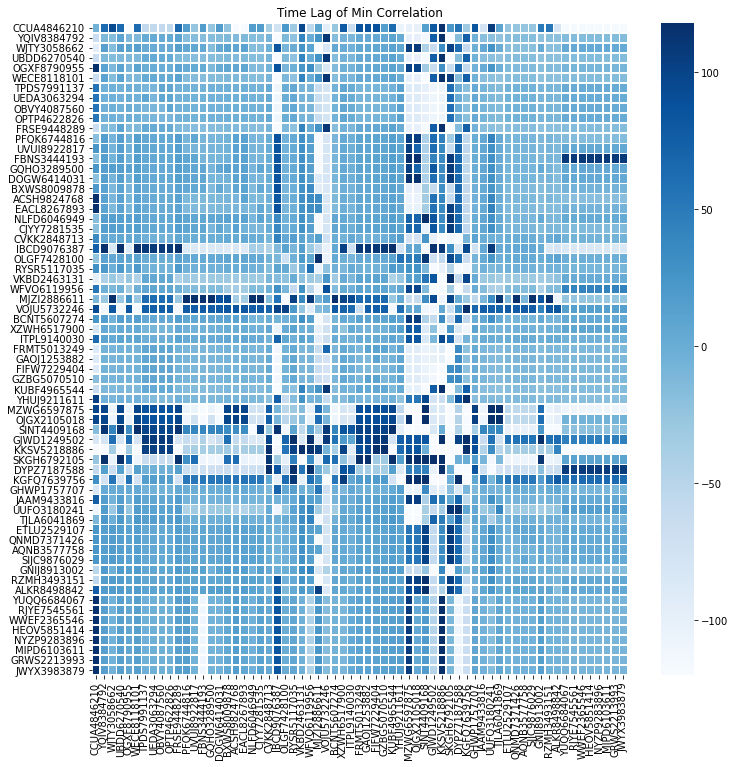

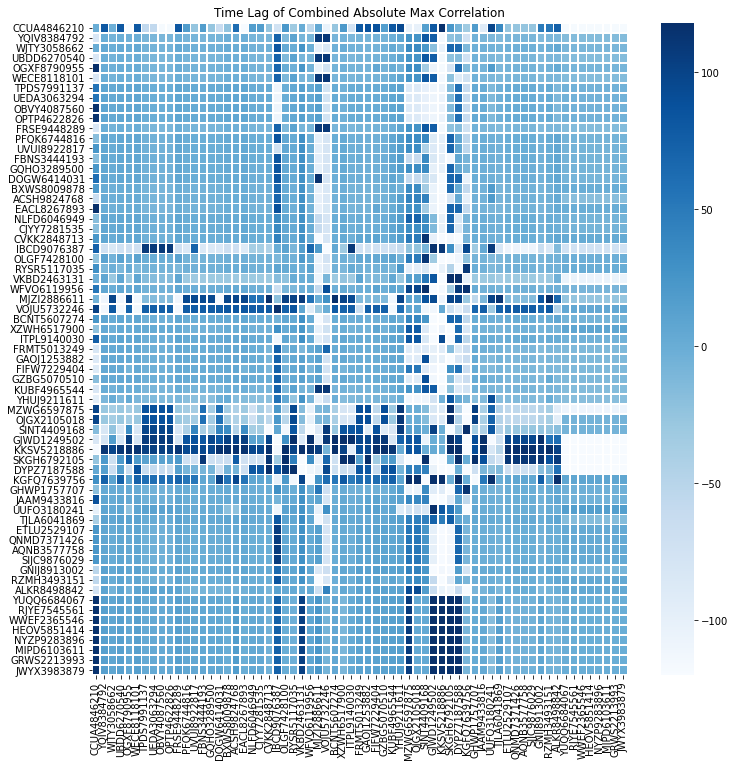

In [30]:
utils.plot_matrix(max_lag_matrix_comp, 
                  title="Time Lag of Max Correlation", 
                  cmap="Blues",
                  xticklabels=all_unique_sensors, 
                  yticklabels=all_unique_sensors,
                 )
plt.show()
utils.plot_matrix(min_lag_matrix_comp, 
                  title="Time Lag of Min Correlation", 
                  cmap="Blues",
                  xticklabels=all_unique_sensors, 
                  yticklabels=all_unique_sensors,
                 )
plt.show()
utils.plot_matrix(combine_lag_matrix_comp, 
                  title="Time Lag of Combined Absolute Max Correlation", 
                  cmap="Blues",
                  xticklabels=all_unique_sensors, 
                  yticklabels=all_unique_sensors,
                 )
plt.show()

## Create matrix df for easier extraction of values

In [31]:
max_df = utils.matrix_to_df(max_matrix, all_unique_sensors)
max_lag_df = utils.matrix_to_df(max_lag_matrix_comp, all_unique_sensors)
min_df = utils.matrix_to_df(min_matrix, all_unique_sensors)
min_lag_df = utils.matrix_to_df(min_lag_matrix_comp, all_unique_sensors)
combine_df = utils.matrix_to_df(combine_matrix, all_unique_sensors)
combine_lag_df = utils.matrix_to_df(combine_lag_matrix_comp, all_unique_sensors)

In [32]:
combine_df

,CCUA4846210,YQIV8384792,WJTY3058662,UBDD6270540,OGXF8790955,WECE8118101,TPDS7991137,UEDA3063294,OBVY4087560,OPTP4622826,FRSE9448289,PFQK6744816,UVUI8922817,FBNS3444193,GQHO3289500,DOGW6414031,BXWS8009878,ACSH9824768,EACL8267893,NLFD6046949,CJYY7281535,CVKK2848713,IBCD9076387,OLGF7428100,RYSR5117035,VKBD2463131,WFVO6119956,MJZI2886611,VOJU5732246,BCNT5607274,XZWH6517900,ITPL9140030,FRMT5013249,GAOJ1253882,FIFW7229404,GZBG5070510,KUBF4965544,YHUJ9211611,MZWG6597875,OJGX2105018,SINT4409168,GJWD1249502,KKSV5218886,SKGH6792105,DYPZ7187588,KGFQ7639756,GHWP1757707,JAAM9433816,UUFO3180241,TJLA6041869,ETLU2529107,QNMD7371426,AQNB3577758,SIJC9876029,GNIJ8913002,RZMH3493151,ALKR8498842,YUQQ6684067,RJYE7545561,WWEF2365546,HEOV5851414,NYZP9283896,MIPD6103611,GRWS2213993,JWYX3983879
CCUA4846210,1.000000,0.029675,0.022645,0.029824,0.022532,0.031403,0.020517,0.020525,0.021005,0.020936,0.028542,0.024150,0.024960,0.023862,0.024536,0.021655,0.022533,0.023326,0.020301,0.024523,0.025225,0.024432,0.026928,0.019498,0.023549,0.020036,0.024091,0.023333,0.026605,0.024761,0.022392,0.019082,0.022466,0.021696,0.025035,0.023192,0.029572,0.024487,0.004572,0.004568,0.003474,0.004576,0.005846,0.003645,0.003936,0.002548,0.026241,0.022456,0.025905,0.020928,0.022037,0.023079,0.022198,0.022207,0.024652,0.025263,0.022094,0.021523,0.021523,0.021523,0.021523,0.021523,0.021523,0.021523,0.021523
YQIV8384792,0.029675,1.000000,0.194455,0.999661,0.324041,0.991910,0.361197,0.361437,0.359796,0.360585,0.998657,0.264617,0.287069,0.301267,0.278403,0.252368,0.306775,0.210086,0.365160,0.350857,0.372305,0.261729,0.040606,0.192310,0.164667,0.125516,0.108073,0.019765,0.026218,0.235345,0.421970,0.330464,0.605357,0.546278,0.594550,0.555504,0.981368,0.064521,0.015208,0.015253,0.009322,0.017348,0.008893,0.010224,0.010264,0.003927,0.429383,0.285736,0.176349,0.322330,0.248828,0.247653,0.247186,0.247286,0.094584,0.216666,0.207467,0.150552,0.150552,0.150552,0.150552,0.150552,0.150552,0.150552,0.150552
WJTY3058662,0.022645,0.194455,1.000000,0.192992,0.650669,0.196408,0.511349,0.511327,0.510699,0.511085,0.194466,0.830064,0.843571,0.848371,0.858081,0.864485,0.609370,0.546441,0.582325,0.819312,0.805017,0.843678,0.027666,0.643635,0.459812,0.311987,0.184300,0.020891,0.040377,0.875653,0.606413,0.667111,0.454566,0.470953,0.446992,0.521316,0.194623,0.056490,0.005828,0.005808,0.006566,0.007556,0.008602,0.005999,0.006254,0.003528,0.478307,0.774163,0.221961,0.491448,0.821987,0.824106,0.820274,0.819554,0.430661,0.797070,0.487678,0.066286,0.066286,0.066286,0.066286,0.066286,0.066286,0.066286,0.066286
UBDD6270540,0.029824,0.999661,0.192992,1.000000,0.322648,0.991749,0.360510,0.360751,0.359102,0.359894,0.998655,0.263040,0.285352,0.299933,0.276560,0.250871,0.306212,0.209726,0.364051,0.348888,0.370643,0.260084,0.040713,0.192361,0.163905,0.124417,0.107598,0.020046,0.026382,0.233587,0.420469,0.329007,0.604852,0.546397,0.594404,0.555061,0.981790,0.064345,0.015264,0.015309,0.009181,0.017453,0.008951,0.010264,0.010273,0.003951,0.428011,0.284057,0.175370,0.321493,0.247296,0.246205,0.245474,0.245575,0.092875,0.215273,0.206300,0.150691,0.150691,0.150691,0.150691,0.150691,0.150691,0.150691,0.150691
OGXF8790955,0.022532,0.324041,0.650669,0.322648,1.000000,0.323595,0.462086,0.462188,0.461085,0.461723,0.322831,0.665202,0.672682,0.695143,0.657741,0.692551,0.817298,0.801160,0.851721,0.664874,0.646841,0.669373,0.026147,0.478492,0.214611,0.261554,0.125349,0.021906,0.033317,0.704719,0.652353,0.574383,0.418423,0.383631,0.348013,0.450594,0.319310,0.064374,0.007348,0.007197,0.008101,0.012063,0.009744,0.007042,0.007319,0.003706,0.483739,0.565897,0.131886,0.426089,0.624540,0.619472,0.615423,0.616227,0.332307,0.509654,0.359564,0.045332,0.045332,0.045332,0.045332,0.045332,0.045332,0.045332,0.045332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Plot a high pair as an example

In [33]:
# get a high corr
combine_df.iloc[6][7] 

0.9999618695908461

In [34]:
# check on which lag the corr was found
combine_lag_df.iloc[6][7]

-1.0

In [35]:
# get a high pair
high_pair = [combine_df.index[6], combine_df.columns[7]]

In [36]:
high_pair

['TPDS7991137', 'UEDA3063294']

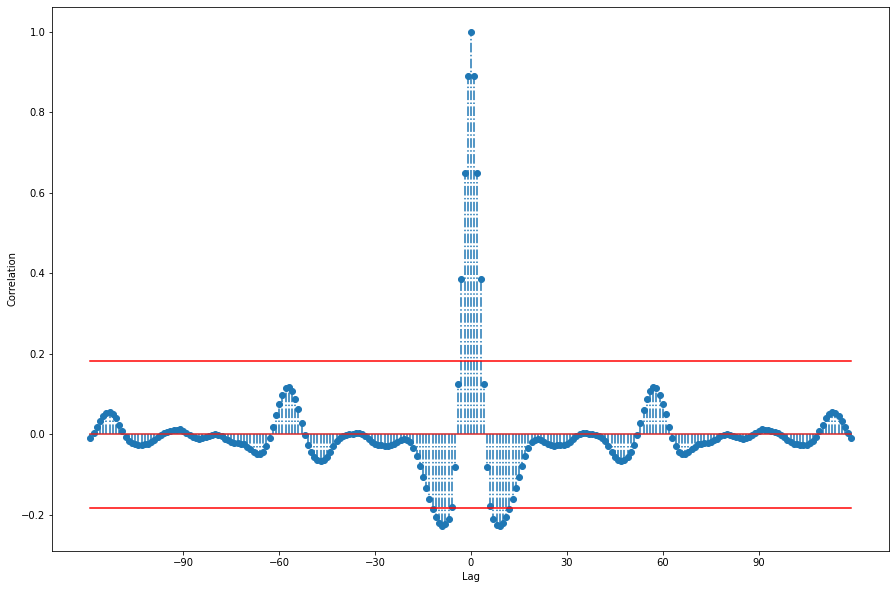

In [37]:
# plot the correlation by lag of the chosen pair
utils.corr_two(input_sensors=high_pair, 
               interpolated_df=smooth_df, 
               max_lags=MAX_LAGS_ONE_DIR, 
               freq=FREQ,
               plot=True,
               data_col=DATA_COL,
              );

Plot both sensors on their interpolated data to check if correlation coincides with what we would expect from the data

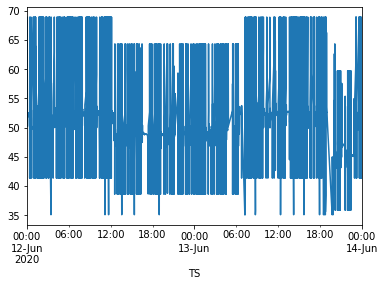

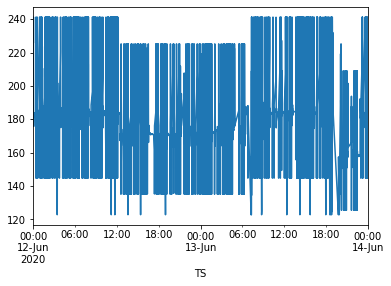

In [38]:
utils.plot_sensor_pair_ts_separate(high_pair, smooth_df)

# Create output overview and save for re-use

Only take the correlation values that are above a certain threshold, because the lower ones are not important

In [39]:
CORR_THRESHOLD

0.5

In [40]:
combine_corr_overview = combine_df[combine_df > CORR_THRESHOLD]

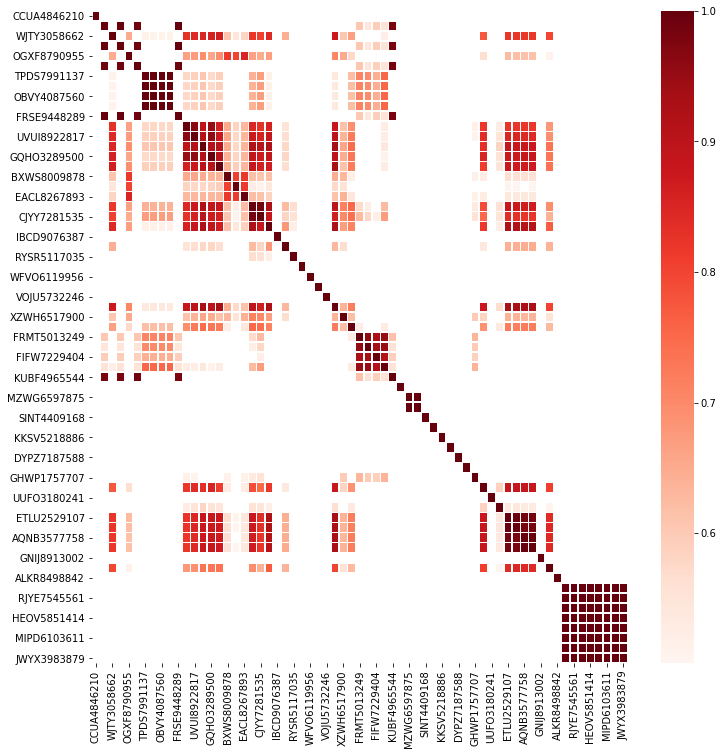

In [41]:
utils.plot_matrix(combine_corr_overview)

In [42]:
combine_output = utils.get_output(matrix = combine_corr_overview,
                                  lag_matrix = combine_lag_df,
                                  sensor_list = all_unique_sensors,
                            )

In [43]:
combine_output

,correlation,lag
"(YQIV8384792, UBDD6270540)",0.999661,-1.0
"(YQIV8384792, WECE8118101)",0.991910,-1.0
"(YQIV8384792, FRSE9448289)",0.998657,-1.0
"(YQIV8384792, FRMT5013249)",0.605357,-7.0
"(YQIV8384792, GAOJ1253882)",0.546278,-7.0
...,...,...
"(JWYX3983879, WWEF2365546)",1.000000,-1.0
"(JWYX3983879, HEOV5851414)",1.000000,-1.0
"(JWYX3983879, NYZP9283896)",1.000000,-1.0
"(JWYX3983879, MIPD6103611)",1.000000,-1.0


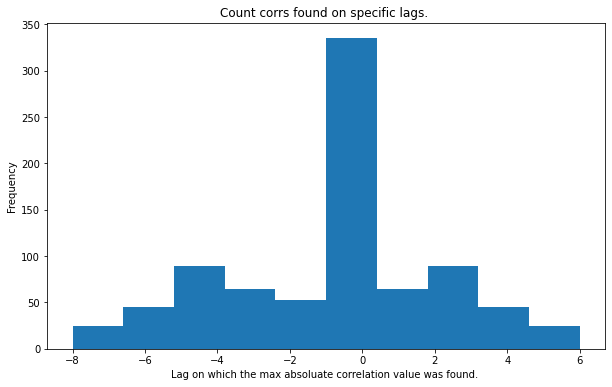

In [44]:
plt.figure(figsize=(10,6))
combine_output['lag'].plot.hist();
plt.xlabel("Lag on which the max absoluate correlation value was found. ");
plt.title("Count corrs found on specific lags. ");

In [45]:
utils.save_combine_output(combine_output)

In [46]:
smooth_df

,Tag,TS,avg,UoM,slope,ma_slope
0,CCUA4846210,2020-06-12 00:00:00,84.27450,flow,-6.227250,-6.227250
1,CCUA4846210,2020-06-12 00:00:05,78.04725,flow,-0.563250,-3.395250
2,CCUA4846210,2020-06-12 00:00:10,83.14800,flow,-5.660625,-4.150375
3,CCUA4846210,2020-06-12 00:00:15,66.72600,flow,-2.950875,-3.850500
4,CCUA4846210,2020-06-12 00:00:20,77.24625,flow,2.841375,-2.512125
...,...,...,...,...,...,...
34556,JWYX3983879,2020-06-13 23:59:40,0.00000,categorical,0.000000,0.000000
34557,JWYX3983879,2020-06-13 23:59:45,0.00000,categorical,0.000000,0.000000
34558,JWYX3983879,2020-06-13 23:59:50,0.00000,categorical,0.000000,0.000000
34559,JWYX3983879,2020-06-13 23:59:55,0.00000,categorical,0.000000,0.000000


In [47]:
utils.save_smooth_df(smooth_df)  